# Limited Word vectors
Optimize the word verctors for the 20 newsgroups

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nltk
from nltk import word_tokenize
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

In [3]:
from sklearn.datasets import fetch_20newsgroups

In [4]:
import gensim
import re

## Helper functions

In [5]:
class LemmaTokenizer(object):
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [6]:
def build_model(sentences, size):
    corpus_words = []
    for session in sentences:
        words = word_tokenize(session)
        session_words = []
        for word in words:
            regex_match = re.match(r"\b[a-zA-Z]+\b", word)
            if (regex_match is not None) & (len(word) > 1) & (word not in stopwords):
                session_words.append(wnl.lemmatize(word.lower()))
        corpus_words.append(session_words)
    model = gensim.models.Word2Vec(corpus_words, size=size, window=5, seed=42,
                                   min_count=2, workers=4)
    return model, corpus_words

In [7]:
def average_vectors(word_list, word2vec_dict, vec_length=5):
    avg_vector = np.zeros(vec_length)
    if len(word_list) == 0:
        return avg_vector
    for word in word_list:
        if word in word2vec_dict.keys():
            avg_vector = np.add(word2vec_dict[word], avg_vector)
    return np.divide(avg_vector, len(word_list))

In [10]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

## Rreduce data to just the content of the message

In [11]:
categories = ['rec.motorcycles', 'rec.autos']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=categories,
                                      remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

In [12]:
df = pd.DataFrame({'msg': newsgroups_train.data,
                   'label': newsgroups_train.target})

In [13]:
df.head(10)

,label,msg
0,0,Stuff deleted...
1,1,This morning a truck that had been within my s...
2,1,So how do I steer when my hands aren't on the ...
3,0,\n: From: OPDBS@vm.cc.latech.edu\n: Subject: T...
4,0,"sorry about that last post, my server neglecte..."
5,1,\n1 hr/drink for the first 4 drinks.\n1.5 hour...
6,1,
7,0,From article <1993Apr5.200048.23421@ucsu.Color...
8,0,Hi Netters\n\tI want to know if 13500 (w/o tax...
9,1,


In [14]:
df.msg.iloc[2]

"So how do I steer when my hands aren't on the bars? (Open Budweiser in left \nhand, Camel cigarette in the right, no feet allowed.) If I lean, and the \nbike turns, am I countersteering? Is countersteering like benchracing only \nwith a taller seat, so your feet aren't on the floor?"

In [15]:
df.msg.iloc[8]

'Hi Netters\n\tI want to know if 13500 (w/o tax) is a good deal for 1993 Mazda 626 DX\nHow is the performance review so far on Mazda 626. Is it a good buy?\nPlease reply to me as I don\'t read this group often.\n\nThanks In advance\nRavi\n--\nRavi Kiran Puvvala\t\t| "The purpose of education is not merely, \nravi@merlin.dev.cdx.mot.com\t|  the assimilation of facts but blow all \nMotorola Codex, Boston  MA \t|  the money" - Ravi Puvvala'

Aggregate each email into an average of the 100 word embeddings

In [16]:
model_100, corpus_words = build_model(newsgroups_train.data, 100)

In [17]:
model_100.wv.doesnt_match(['wheel', 'car', 'wave'])

'wave'

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

In [19]:
skf = StratifiedKFold(n_splits=4)

My hypothesis is that large vectors will overfit the model. So if we have a dataset of 100 words, embeddings of lower dimensionality would be better. Want to show that as you make the model more comple, you lose generality

In [20]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [21]:
X = newsgroups_train.data
y = newsgroups_train.target
X_majority, X_sample, y_majority, y_sample = train_test_split(X, y, test_size=0.8, random_state=42)

In [22]:
len(X_sample)

954

Iterate over the size of the word vectors. Should see low score, then a max, then a decrease

In [23]:
X_sample = np.array(X_sample)
y_sample = np.array(y_sample)

In [24]:
from sklearn.svm import SVC

In [25]:
svm = SVC(C=1e6)

In [26]:
skf = StratifiedKFold(n_splits=4)

In [29]:
for train_index, test_index in skf.split(X_sample, y_sample):
    X_train, X_test = X_sample[train_index], X_sample[test_index]
    
    y_train, y_test = y_sample[train_index], y_sample[test_index]
    print(len(X_train), len(y_train))

715 715
715 715
716 716
716 716


In [30]:
w2v = dict(zip(model_100.wv.index2word, model_100.wv.vectors))
vectors = []
for email in X_train:
    email_vector = average_vectors(email, w2v, vec_length=100)
    vectors.append(email_vector)

In [31]:
len(vectors)

716

In [33]:
model_100.wv.doesnt_match(['wheel', 'car', 'wave'])

'wave'

In [34]:
clf = svm.fit(vectors, y_train)

In [35]:
clf.score(vectors, y_train)

0.6019553072625698

Why does this model suck so much?

In [36]:
from sklearn.model_selection import validation_curve

In [37]:
len(y_train)

716

In [44]:
reg_params = np.logspace(0, 8, num=5)
train_scores, valid_scores = validation_curve(clf, 
                                              vectors, y_train, "C",
                                              reg_params,
                                              cv=4,
                                              n_jobs=2,
                                              verbose=2
                                              )

[CV] C=1.0 ...........................................................
[CV] C=100.0 .........................................................
[CV] ............................................ C=1.0, total=   0.0s
[CV] C=10000.0 .......................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=1000000.0 .....................................................
[CV] ........................................ C=10000.0, total=   0.0s
[CV] C=100000000.0 ...................................................
[CV] ...................................... C=1000000.0, total=   0.1s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=   0.0s
[CV] C=100.0 .........................................................
[CV] .................................... C=100000000.0, total=   0.1s
[CV] C=10000.0 .......................................................
[CV] .

[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.6s remaining:    0.6s


[CV] .................................... C=100000000.0, total=   0.1s
[CV] C=100.0 .........................................................
[CV] ............................................ C=1.0, total=   0.0s
[CV] C=10000.0 .......................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=1000000.0 .....................................................
[CV] ........................................ C=10000.0, total=   0.0s
[CV] C=100000000.0 ...................................................
[CV] ...................................... C=1000000.0, total=   0.1s
[CV] .................................... C=100000000.0, total=   0.2s


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.1s finished


In [45]:
test_scores = valid_scores
train_sizes = reg_params

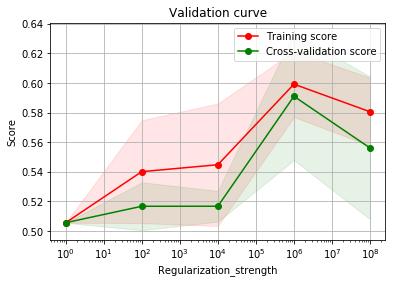

In [46]:
plt.figure()
plt.title('Validation curve')
plt.semilogx()
plt.xlabel('Regularization_strength')
plt.ylabel('Score')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.savefig('../docs/small_data_regularization_curve.png')
plt.show()

In [ ]:
for n_words in range(20, 100, 20):
    model, corpus_words = build_model(X_sample, n_words)
    skf = StratifiedKFold(n_splits=4)
    # evaluate model performance on 4 fold cross validation
    for train_index, test_index in skf.split(X_sample, y_sample):
        X_train, X_test = X_sample[train_index], X_sample[test_index]
        y_train, y_test = y_sample[train_index], y_sample[test_index]
        w2v = dict(zip(model.wv.index2word, model.wv.vectors))
        X_train = []
        for email in X_train:
            email_vector = average_vectors(email, w2v, vec_length=100)
            vectors.append(email_vector)
            svm = SVC(C=1e6)
            clf = svm.fit(X_train, y_train)
        

In [ ]:
model_100, corpus_words = build_model(small_df.data, 100)
vectors = [] 
for email in corpus_words:
    email_vector = average_vectors(email, w2v, vec_length=100)
    vectors.append(email_vector)

In [ ]:
for data_size in range(200, 1000, 200):
    data_sample = df.sample(n=data_size, random_state=42)
    model_100, corpus_words = build_model(newsgroups_train.data, 100)
    vectors = []
    for email in corpus_words:
        email_vector = average_vectors(email, w2v, vec_length=100)
        vectors.append(email_vector)

In [ ]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

In [ ]:
model_100, corpus_words = build_model(newsgroups_train.data, 100)

In [ ]:
corpus_words

In [ ]:
len(model_100.wv.vocab)

In [ ]:
model_100.wv.doesnt_match(['wheel', 'car', 'wave'])

In [ ]:
w2v = dict(zip(model_100.wv.index2word, model_100.wv.vectors))

## Vectorize the contents of the email

In [ ]:
vectors = []
for email in corpus_words:
    email_vector = average_vectors(email, w2v, vec_length=100)
    vectors.append(email_vector)

In [ ]:
matrix = np.array(vectors)
matrix.shape

In [ ]:
from sklearn.decomposition import PCA
sns.set()

In [ ]:
pca = PCA(n_components=2)

In [ ]:
twod = pca.fit_transform(matrix)

In [ ]:
newsgroups_train.target

In [ ]:
matrix.shape

In [ ]:
car_emails = twod[np.where(newsgroups_train.target == 0), :][0, :, :]
moto_emails = twod[np.where(newsgroups_train.target == 1), :][0, :, :]

In [ ]:
car_emails.shape

Plot the vectorization of car and moto emails

In [ ]:
plt.scatter(x = car_emails[:, 0], y=car_emails[:, 1], c='r')
plt.scatter(x = moto_emails[:, 0], y=moto_emails[:, 1], c='b')

Not very sperable, see if TSNE can work as inspirded by https://blog.insightdatascience.com/automating-customer-support-when-you-lack-data-e9975fd8a053 

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, early_exaggeration=12,
            learning_rate=100, n_iter=1000, n_iter_without_progress=300,
            verbose=1, method='barnes_hut')

In [ ]:
tsne_twod = tsne.fit_transform(matrix)

In [ ]:
car_emails = tsne_twod[np.where(newsgroups_train.target == 0), :][0, :, :]
moto_emails = tsne_twod[np.where(newsgroups_train.target == 1), :][0, :, :]

In [ ]:
plt.scatter(x = car_emails[:, 0], y=car_emails[:, 1], c='r')
plt.scatter(x = moto_emails[:, 0], y=moto_emails[:, 1], c='b')

## Plot the word embeddings
Get the top 20 nouns and plot them

In [ ]:
from collections import Counter

In [ ]:
word_count = Counter()
for doc in newsgroups_train.data:
    word_list = [wnl.lemmatize(x.lower()) for x in doc.split() if x not in stopwords]
    word_count = word_count + Counter(word_list)

In [ ]:
word_count.most_common(n=5)

Not super helpful, hardcode the most important words

### 2D word vectorization whent training

In [ ]:
model_2, corpus_words = build_model(newsgroups_train.data, 2)

In [ ]:
model_2.wv['motor']

In [ ]:
labels = model_2.wv.vocab.keys()

In [ ]:
car_words = ['motor', 'engine', 'wheel', 'tire', 'window', 'wiper',
             'gasoline', 'fuel', 'speed', 'accelerate', 'throttle',
             'pad', 'wave']

In [ ]:
for word in car_words:
    x = model_2.wv[word][0]
    y = model_2.wv[word][1]
    plt.plot(x, y, 'bo')
    plt.text(x * (1+0.01), y*(1+0.01), word, fontsize=18)
plt.show()    

That doesn't make that much sense

In [ ]:
model_100.wv.doesnt_match(['wheel', 'car', 'wave'])

In [ ]:
model_2.wv.doesnt_match(['wheel', 'car', 'wave'])